In [1]:
import qiskit
from qiskit.circuit.library import QFT
from circuit_knitting.cutting.cutqc import cut_circuit_wires
import mitiq
from qiskit.qasm2 import dumps
from qiskit.providers.fake_provider.backends_v1 import Fake20QV1
from circuit_knitting.cutting.cutqc import reconstruct_full_distribution, evaluate_subcircuits
from qiskit import QuantumCircuit


In [20]:
from cirq.contrib.qasm_import import circuit_from_qasm
qf = qiskit.QuantumCircuit(4)
qf.h(0)
qf.cx(0,1)
qf.cx(1,2)
qf.cx(2,3)
qf.measure_all()
def is_circuit_clifford(circuit, skip_transpile = False):
    if not skip_transpile:
        rb = qiskit.transpiler.passes.RemoveBarriers()
        circuit = qiskit.transpile(circuit, backend=Fake20QV1())
        
        circuit = rb(circuit)
    cqasm = dumps(circuit)
    circuit = circuit_from_qasm(cqasm)
    return mitiq.cdr.clifford_utils.is_clifford(circuit)

def SplitandCombine(circuit):
    cuts = cut_circuit_wires(
    circuit=circuit,
    method="automatic",
    max_subcircuit_width=15,
    max_cuts=2,
    num_subcircuits=[2])
    eval_list = []
    fn = 0
    for c in cuts['subcircuits']:
        c.draw(output='mpl', filename = str(fn)+".jpg")
        fn += 1
        if c.num_qubits < 3:
            eval_list.append('aer_simulator')
            continue
        if is_circuit_clifford(c):
            eval_list.append('clifford_simulator')
        else:
            eval_list.append('ibmq_qasm_simulator')
    print(eval_list)
    subcircuit_instance_probabilities = evaluate_subcircuits(cuts, backend_names = eval_list)
    reconstructed_probabilities = reconstruct_full_distribution(circuit, subcircuit_instance_probabilities, cuts)

    return reconstructed_probabilities

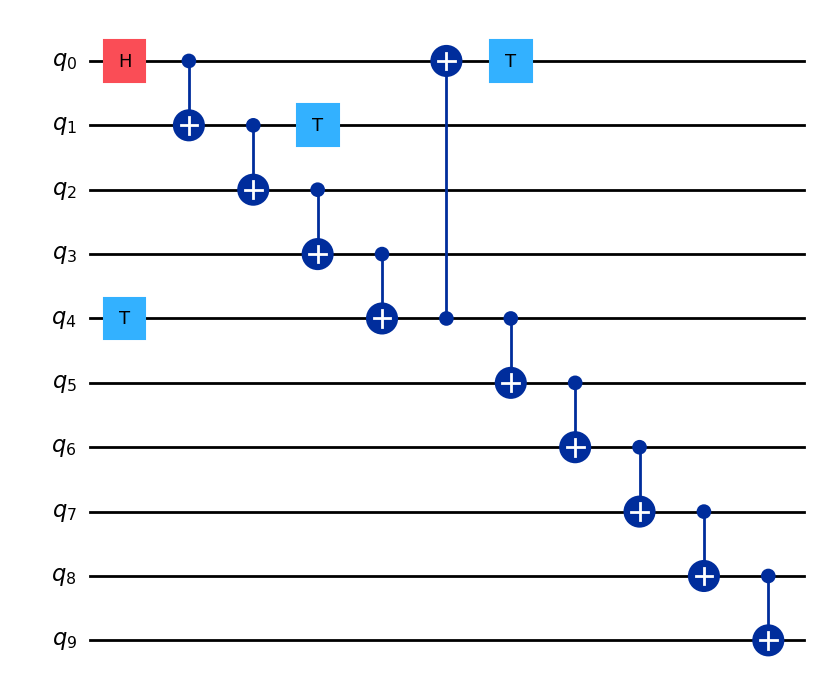

In [21]:
qc = QuantumCircuit(10)

qc.h(0)
qc.t(4)
for i in range(9):
    if i == 4:
        qc.cx(i, 0)
    qc.cx(i, i+1)


qc.t(0)
qc.t(1)
qc.draw(output='mpl')

In [22]:
SplitandCombine(qc)

Exporting as a LP file to let you check the model that will be solved :  inf <class 'float'>
Version identifier: 22.1.1.0 | 2023-02-11 | 22d6266e5
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               300
Tried aggregator 3 times.
MIP Presolve eliminated 37 rows and 8 columns.
MIP Presolve modified 7 coefficients.
Aggregator did 61 substitutions.
Reduced MIP has 164 rows, 61 columns, and 492 nonzeros.
Reduced MIP has 57 binaries, 4 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.05 ticks)
Found incumbent of value 2.000000 after 0.01 sec. (1.13 ticks)
Probing fixed 2 vars, tightened 0 bounds.
Probing changed sense of 2 constraints.
Probing time = 0.00 sec. (0.39 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 17 rows and 17 columns.
MIP Presolve modified 9 coefficients.
Aggregator did 2 substitutions.
Reduced MIP has 145 rows, 42 columns, and 438 nonzeros.
Reduced MIP has 38 binaries, 4 generals, 0 SOSs, and 0 indic

['ibmq_qasm_simulator', 'clifford_simulator']


array([0.5, 0. , 0. , ..., 0. , 0.5, 0. ])